This notebook will show you how to create you custom VMAS scenario from scratch and train it in BenchMARL.

We will create a scenario where multiple robots with different embodiments need to navigate to their goals while avoiding each other and obstacles.

The result will look something like this:

![](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/tutorial_gifs/Trainwithphysicallyheterogeneousagents.gif)

You can run both sections together or each one independently.

# VMAS: creating a custom scenario



VMAS is a vectorized multi-agent simulator but also a collection of scenarios.

The best way to learn how VMAS works is to implement your own scenario, which is the focus of this section of the notebook.

![vmas_diagram](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/VMAS_diagram.png)


## Installing depdendencies

In [ ]:
# @title Rendering dependencies
!apt-get update
!apt-get install -y x11-utils python3-opengl xvfb
!pip install pyvirtualdisplay
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

In [ ]:
# @title Install vmas
!pip install vmas

## Creating a scenario



To implement a scenario, there are some compulsory and optional functions that need to be created, let's see wat they are:

In [3]:
from vmas.simulator.scenario import BaseScenario

class MyScenario(BaseScenario):

    def make_world(self, batch_dim, device, **kwargs):
        raise NotImplementedError()

    def reset_world_at(self, env_index):
        raise NotImplementedError()

    def observation(self, agent):
        raise NotImplementedError()

    def reward(self, agent):
        raise NotImplementedError()

We will now implement and explain them one by one.

The scenario we will create is a version of multi-agent [navigation](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/scenarios/navigation.gif).

In this scenario, randomly spawned agents (colored shapes with surrounding dots) need to navigate to randomly spawned goals (smaller circles of the same color as the agent). Agents need to use LIDARs (dots around them telling distances to other agents) to avoid colliding into each other. They also need to avoid collisions with surrounding obstacles (black circles). Agents act in a 2D continuous world with drag and elastic collisions.

In VMAS, the `entity` is the base concept. Entities can be agents or landmarks.
The difference between the 2 is that agents can act and receive rewards and observations.

We will discuss in depth actions, rewards, and observations in the respective sections.

This scenario creation tutorial **WILL** showcase the following VMAS features:
- The voctorized nature of VMAS
- The ability to simulate agents with different dynamics (we will use holonomic, differential drive, and car agents)
- The ability to add sensors to the agents (we will use LIDARs)
- The ability of simulating physics and collisions for agents with different shapes

This scenario creation tutorial **WILL NOT** showcase the following VMAS features:
- Joints (see the waterfall debug scenario for an example)
- Custom gravity
- The differentiability of the simulator
- Customising friction and drag
- Using controllers to change the input (e.g., using velocities instead of forces for input)
- Using heuristic (scripted) controllers for some of the agents
- Plotting a function under the task rendering
- Competitive scenarios
- Many more (sorry, VMAS has a lot to offer and we have limited time)

### `make_world`

Our first function!!

Here is where we decide what will be in our world (agents, landmarks) and some configuration parameters for it.

In order, this function does:

1.   First things first, we will define the parameters of our scenario, reading from `kwargs` and definining the default values for them.
2.   Then, we will create the world object, this is the component where the physics simulation lies, containing all our agents and landmarks.
3.   Then, we add our agents, which are of 3 types: holonomic, differential drive, and car (bicycle). For each agent we define shape, collidability, action, ranges, dynamics, etc.
4.   Each agent is equipped with a LIDAR that has a filter allowing it to sense only other agents (we will give obstacle positions directly in the observations without sensing)
5.   We add a landmark for each agent representing its goal
6.   Finally, we add obstacles that the agents need to avoid




In [4]:
import typing
from typing import Dict, List

import torch
from torch import Tensor

from vmas.simulator.core import Agent, Box, Landmark, Sphere, World
from vmas.simulator.dynamics.diff_drive import DiffDrive
from vmas.simulator.dynamics.holonomic import Holonomic
from vmas.simulator.dynamics.kinematic_bicycle import KinematicBicycle
from vmas.simulator.scenario import BaseScenario
from vmas.simulator.sensors import Lidar
from vmas.simulator.utils import (
    ANGULAR_FRICTION,
    Color,
    DRAG,
    LINEAR_FRICTION,
    ScenarioUtils,
)

if typing.TYPE_CHECKING:
    from vmas.simulator.rendering import Geom


def make_world(self, batch_dim: int, device: torch.device, **kwargs):
    ################
    # Scenario configuration
    ################
    self.plot_grid = False  # You can use this to plot a grid under the rendering for visualization purposes

    self.n_agents_holonomic = kwargs.pop(
        "n_agents_holonomic", 2
    )  # Number of agents with holonomic dynamics
    self.n_agents_diff_drive = kwargs.pop(
        "n_agents_diff_drive", 1
    )  # Number of agents with differential drive dynamics
    self.n_agents_car = kwargs.pop(
        "n_agents_car", 1
    )  # Number of agents with car dynamics
    self.n_agents = (
        self.n_agents_holonomic + self.n_agents_diff_drive + self.n_agents_car
    )
    self.n_obstacles = kwargs.pop("n_obstacles", 2)

    self.world_spawning_x = kwargs.pop(
        "world_spawning_x", 1
    )  # X-coordinate limit for entities spawning
    self.world_spawning_y = kwargs.pop(
        "world_spawning_y", 1
    )  # Y-coordinate limit for entities spawning

    self.comms_rendering_range = kwargs.pop(
        "comms_rendering_range", 0
    )  # Used for rendering communication lines between agents (just visual)
    self.lidar_range = kwargs.pop("lidar_range", 0.3)  # Range of the LIDAR sensor
    self.n_lidar_rays = kwargs.pop(
        "n_lidar_rays", 12
    )  # Number of LIDAR rays around the agent, each ray gives an observation between 0 and lidar_range

    self.shared_rew = kwargs.pop(
        "shared_rew", False
    )  # Whether the agents get a global or local reward for going to their goals
    self.final_reward = kwargs.pop(
        "final_reward", 0.01
    )  # Final reward that all the agents get when the scenario is done
    self.agent_collision_penalty = kwargs.pop(
        "agent_collision_penalty", -1
    )  # Penalty reward that an agent gets for colliding with another agent or obstacle

    self.agent_radius = kwargs.pop("agent_radius", 0.1)
    self.min_distance_between_entities = (
        self.agent_radius * 2 + 0.05
    )  # Minimum distance between entities at spawning time
    self.min_collision_distance = (
        0.005  # Minimum distance between entities for collision trigger
    )

    ScenarioUtils.check_kwargs_consumed(kwargs) # Warn if not all kwargs have been consumed


    ################
    # Make world
    ################
    world = World(
        batch_dim,  # Number of environments simulated
        device,  # Device for simulation
        substeps=5,  # Number of physical substeps (more yields more accurate but more expensive physics)
        collision_force=500,  # Paramneter to tune for collisions
        dt=0.1,  # Simulation timestep
        gravity=(0.0, 0.0),  # Customizable gravity
        drag=DRAG,  # Physics parameters
        linear_friction=LINEAR_FRICTION,  # Physics parameters
        angular_friction=ANGULAR_FRICTION,  # Physics parameters
        # There are many more....
    )

    ################
    # Add agents
    ################
    known_colors = [
        Color.BLUE,
        Color.ORANGE,
        Color.GREEN,
        Color.PINK,
        Color.PURPLE,
        Color.YELLOW,
        Color.RED,
    ]  # Colors for the first 7 agents
    colors = torch.randn(
        (max(self.n_agents - len(known_colors), 0), 3), device=device
    )  # Other colors if we have more agents are random

    self.goals = []  # We will store our agents' goal entities here for easy access
    for i in range(self.n_agents):
        color = (
            known_colors[i]
            if i < len(known_colors)
            else colors[i - len(known_colors)]
        )  # Get color for agent

        sensors = [
            Lidar(
                world,
                n_rays=self.n_lidar_rays,
                max_range=self.lidar_range,
                entity_filter=lambda e: isinstance(
                    e, Agent
                ),  # This makes sure that this lidar only percieves other agents
                angle_start=0.0,  # LIDAR angular ranges (we sense 360 degrees)
                angle_end=2
                * torch.pi,  # LIDAR angular ranges (we sense 360 degrees)
            )
        ]  # Agent LIDAR sensor

        if i < self.n_agents_holonomic:
            agent = Agent(
                name=f"holonomic_{i}",
                collide=True,
                color=color,
                render_action=True,
                sensors=sensors,
                shape=Sphere(radius=self.agent_radius),
                u_range=[1, 1],  # Ranges for actions
                u_multiplier=[1, 1],  # Action multipliers
                dynamics=Holonomic(),  # If you got to its class you can see it has 2 actions: force_x, and force_y
            )
        elif i < self.n_agents_holonomic + self.n_agents_diff_drive:
            agent = Agent(
                name=f"diff_drive_{i - self.n_agents_holonomic}",
                collide=True,
                color=color,
                render_action=True,
                sensors=sensors,
                shape=Sphere(radius=self.agent_radius),
                u_range=[1, 1],  # Ranges for actions
                u_multiplier=[0.5, 1],  # Action multipliers
                dynamics=DiffDrive(
                    world
                ),  # If you go to its class you can see it has 2 actions: forward velocity and angular velocity
            )
        else:
            max_steering_angle = torch.pi / 4
            width = self.agent_radius
            agent = Agent(
                name=f"car_{i-self.n_agents_holonomic-self.n_agents_diff_drive}",
                collide=True,
                color=color,
                render_action=True,
                sensors=sensors,
                shape=Box(length=self.agent_radius * 2, width=width),
                u_range=[1, max_steering_angle],
                u_multiplier=[0.5, 1],
                dynamics=KinematicBicycle(
                    world,
                    width=width,
                    l_f=self.agent_radius,  # Distance between the front axle and the center of gravity
                    l_r=self.agent_radius,  # Distance between the rear axle and the center of gravity
                    max_steering_angle=max_steering_angle,
                ),  # If you got to its class you can see it has 2 actions: forward velocity and steering angle
            )
        agent.pos_rew = torch.zeros(
            batch_dim, device=device
        )  # Tensor that will hold the position reward fo the agent
        agent.agent_collision_rew = (
            agent.pos_rew.clone()
        )  # Tensor that will hold the collision reward fo the agent

        world.add_agent(agent)  # Add the agent to the world

        ################
        # Add goals
        ################
        goal = Landmark(
            name=f"goal_{i}",
            collide=False,
            color=color,
        )
        world.add_landmark(goal)
        agent.goal = goal
        self.goals.append(goal)

    ################
    # Add obstacles
    ################
    self.obstacles = (
        []
    )  # We will store obstacles here for easy access
    for i in range(self.n_obstacles):
        obstacle = Landmark(
            name=f"obstacle_{i}",
            collide=True,
            color=Color.BLACK,
            shape=Sphere(radius=self.agent_radius * 2 / 3),
        )
        world.add_landmark(obstacle)
        self.obstacles.append(obstacle)

    self.pos_rew = torch.zeros(
        batch_dim, device=device
    )  # Tensor that will hold the global position reward
    self.final_rew = (
        self.pos_rew.clone()
    )  # Tensor that will hold the global done reward
    self.all_goal_reached = (
        self.pos_rew.clone()
    )  # Tensor indicating if all goals have been reached

    return world

MyScenario.make_world = make_world

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### `reset_world_at`

This is the function where you need to reset the world state.

Being a vectorized simulator, every tensor in VMAS has a leading batch dimension, representing all the environments being simulated.
For example, imagine we have `num_envs=16`, the position of an agent (available at `agent.state.pos`) will have shape `[num_envs,2]`. The same goes for other state variables (velocity, force action, rotation, etc).

Vectorization means that with a position `pos` and a velocity `vel` of shape  `pos.shape=[num_envs,2]` you can do
```python
pos = pos + vel * dt
```
which will automatically compute the next position for all `num_envs` environments, avoiding any for loops.

This is the key principle motivating VMAS.

Now, some of these environments can terminate before others. This function has to deal with that. It will be called in 2 situations:
- `env_index=None` meaning it needs to reset all enviornments
- `env_index=x` meaning it has to reset only the environment at index `x`

When setting specific positions you can use `agent.set_pos` or `agent.set_rot`.
More examples on this are avaialble at https://vmas.readthedocs.io/en/latest/generated/vmas.simulator.scenario.BaseScenario.html#vmas.simulator.scenario.BaseScenario.reset_world_at

For our task, we want to spawn agents, obstacles, and goals at random (but still not on top of each other). This is so that every time the scenario is reset the task setup is different. We call this domain randomization.

Fortunately the is a very simple util that helps us in this.



In [5]:
def reset_world_at(self, env_index: int = None):
    ScenarioUtils.spawn_entities_randomly(
        self.world.agents
        + self.obstacles
        + self.goals,  # List of entities to spawn
        self.world,
        env_index, # Pass the env_index so we only reset what needs resetting
        self.min_distance_between_entities,
        x_bounds=(-self.world_spawning_x, self.world_spawning_x),
        y_bounds=(-self.world_spawning_y, self.world_spawning_y),
    )

    for agent in self.world.agents:
        if env_index is None:
            agent.goal_dist = torch.linalg.vector_norm(
                agent.state.pos - agent.goal.state.pos,
                dim=-1,
            )  # Tensor holding the distance of the agent to the goal, we will use it to compute the reward
        else:
            agent.goal_dist[env_index] = torch.linalg.vector_norm(
                agent.state.pos[env_index] - agent.goal.state.pos[env_index]
            )

MyScenario.reset_world_at = reset_world_at

### `reward`

The key component of RL: the feedback!

This function simply returns the reward for an agent as a tensor of shape `[num_envs]`

We have 3 types of rewards:


1.   `pos_rew`. The most important, this is the reward that incetivates agents to go to their goal. If you are first approaching RL you might think that `pos_rew = -distance_to_goal` would be good for this. But it is not. This is because it will depend on the absolute distance and, thus, be really high when the agent is far away and really low when it is close by. A better choice for this reward is `pos_rew = previous_distance_to_goal - distance_to_goal`. This makes it so that if the agent moves 1m towards the goal it is rewarded the same amount regardless of its absolute distance to it, making training more stable.
We have a `pos_rew` for each agent and a global one (which is their sum). We can train with either depending on the `self.shared_rew` configuration settings.
2.   `agent_collision_rew` is simply a penalty for agent-agent and agent-obstacle collisions. This is always local (per-agent).
3.   `final_rew` is given to all agents for reaching all their goals. This is always global and is not really fundamental in this task, but helps with training.



In [6]:
def reward(self, agent: Agent):
    is_first = agent == self.world.agents[0]

    if is_first:
        # We can compute rewards when the first agent is called such that we do not have to recompute global components

        self.pos_rew[:] = 0  # Reset previous reward
        self.final_rew[:] = 0  # Reset previous reward

        for a in self.world.agents:
            a.agent_collision_rew[:] = 0  # Reset previous reward
            distance_to_goal = torch.linalg.vector_norm(
                a.state.pos - a.goal.state.pos,
                dim=-1,
            )
            a.on_goal = distance_to_goal < a.shape.circumscribed_radius()

            # The positional reward is the delta in distance to the goal.
            # This makes it so that if the agent moves 1m towards the goal it is rewarded
            # the same amount regardless of its absolute distance to it
            # This would not be the case if pos_rew = -distance_to_goal (a common choice)
            # This choice leads to better training
            a.pos_rew = a.goal_dist - distance_to_goal

            a.goal_dist = distance_to_goal  # Update distance to goal
            self.pos_rew += a.pos_rew  # Global pos reward

        # If all agents reached their goal we give them all a final_rew
        self.all_goal_reached = torch.all(
            torch.stack([a.on_goal for a in self.world.agents], dim=-1),
            dim=-1,
        )
        self.final_rew[self.all_goal_reached] = self.final_reward

        for i, a in enumerate(self.world.agents):
            # Agent-agent collision
            for j, b in enumerate(self.world.agents):
                if i <= j:
                    continue
                if self.world.collides(a, b):
                    distance = self.world.get_distance(a, b)
                    a.agent_collision_rew[
                        distance <= self.min_collision_distance
                    ] += self.agent_collision_penalty
                    b.agent_collision_rew[
                        distance <= self.min_collision_distance
                    ] += self.agent_collision_penalty
            # Agent obstacle collision
            for b in self.obstacles:
                if self.world.collides(a, b):
                    distance = self.world.get_distance(a, b)
                    a.agent_collision_rew[
                        distance <= self.min_collision_distance
                    ] += self.agent_collision_penalty

    pos_reward = (
        self.pos_rew if self.shared_rew else agent.pos_rew
    )  # Choose global or local reward based on configuration
    return pos_reward + self.final_rew + agent.agent_collision_rew

MyScenario.reward = reward

### `observation`

What the agent gets as input to compute the action. This can be a tensor of shape `[num_envs, num_obs]` or a dictionary of such tensors.

There is not much difference, but if we use a dictionary we can separate observations based on their semantics. As we will see later, this is useful as we will be able to read position and velocity to compute edge features in a graph neural network (GNN).

We have additional observations for non-holonomic agents as they will need angular states.

In [7]:
def observation(self, agent: Agent):
    obs = {
        "obs": torch.cat(
            [
                agent.state.pos - agent.goal.state.pos
            ]  # Relative position to goal (fundamental)
            + [
                agent.state.pos - obstacle.state.pos for obstacle in self.obstacles
            ]  # Relative position to obstacles (fundamental)
            + [
                sensor._max_range - sensor.measure() for sensor in agent.sensors
            ],  # LIDAR to avoid other agents
            dim=-1,
        ),
        "pos": agent.state.pos,
        "vel": agent.state.vel,
    }
    if not isinstance(agent.dynamics, Holonomic):
        # Non hoonomic agents need to know angular states
        obs.update(
            {
                "rot": agent.state.rot,
                "ang_vel": agent.state.ang_vel,
            }
        )
    return obs

MyScenario.observation = observation

### `done`

This is an optional function that returns a boolean tensor of shape `[num_envs]`, representing what environments are done.

If this function is not implemented, the environment will be done after the (optional) `max_steps` provided at environment construction time.

By default, termination (the `done` function of the scneario) and truncation (the done flag after the specified `max_steps`) are the same thing and both set a global done.

> **_NOTE:_** If you want to keep them separate, you can set `terminated_truncated=True` at environment construction.

In this scenario, we will set the done flag when all agents have reached their destinations

In [8]:
def done(self) -> Tensor:
    return self.all_goal_reached

MyScenario.done = done

### `info`

This is another optional function used to return useful info for logging.

The format of the returned data should be a dictionary with string keys and values being tensors that have a leading dimension `num_envs`.

In this scenario we return information about the components that make up the rewards. This allows us to monitor at a closer granularity theor progression.

In [9]:
def info(self, agent: Agent) -> Dict[str, Tensor]:
    return {
        "pos_rew": self.pos_rew if self.shared_rew else agent.pos_rew,
        "final_rew": self.final_rew,
        "agent_collision_rew": agent.agent_collision_rew,
    }

MyScenario.info = info

### `extra_render`

This is another optional function we will use to plot extra elements in our scneario that are just for visual purposes.

In this case, we use it to plot the current rotations of non-holonomic agents and the communication lines in case communication range is used

In [10]:
def extra_render(self, env_index: int = 0) -> "List[Geom]":
    from vmas.simulator import rendering

    geoms = [
        ScenarioUtils.plot_entity_rotation(agent, env_index)
        for agent in self.world.agents
        if not isinstance(agent.dynamics, Holonomic)
    ]  # Plot the rotation for non-holonomic agents

    # Plot communication lines
    if self.comms_rendering_range > 0:
        for i, agent1 in enumerate(self.world.agents):
            for j, agent2 in enumerate(self.world.agents):
                if j <= i:
                    continue
                agent_dist = torch.linalg.vector_norm(
                    agent1.state.pos - agent2.state.pos, dim=-1
                )
                if agent_dist[env_index] <= self.comms_rendering_range:
                    color = Color.BLACK.value
                    line = rendering.Line(
                        (agent1.state.pos[env_index]),
                        (agent2.state.pos[env_index]),
                        width=1,
                    )
                    line.set_color(*color)
                    geoms.append(line)
    return geoms

MyScenario.extra_render = extra_render

## Creating the enviornment

Let's now create our enviornment and inspect its interface.

Let's first setup some parameters:

These will let us decide how many holonomic agents we want, how many differential drive ones, and how many cars.

Here you can also decide the device for VMAS simulation (you can use "cuda", if available) and the number of environments to simulate in the vectorised batch.

In [11]:
# @title Scenario parameters
n_agents_holonomic = 2 # @param {"type":"integer"}
n_agents_diff_drive = 1 # @param {"type":"integer"}
n_agents_car = 1 # @param {"type":"integer"}
n_obstacles = 2 # @param {"type":"integer"}

vmas_device = "cpu" # @param {"type":"string"}
num_envs = 8 # @param {"type":"integer"}

Now we create the enviornment

In [12]:
from vmas import make_env
env = make_env(
    scenario=MyScenario(),
    num_envs=num_envs,
    device=vmas_device,
    seed=0,
    # Optional parameters, we use the defaults
    continuous_actions=True,
    max_steps=None, # We just use the scenario done
    dict_spaces=False, # Whether observations, infos, and rewards are dictionaries mapping agent name to data or lists. For more info see https://github.com/proroklab/VectorizedMultiAgentSimulator?tab=readme-ov-file#output-spaces
    multidiscrete_actions=False, # In case of discrete actions, whether to use multidiscrete spaces of just bigger discrete ones. Not relevant here
    grad_enabled=False, # Whether we run the simulator in a differentiable manner
    terminated_truncated=False, # Whether to separate terminate and truncated into distinct flags
    # Scenario parameters
    n_agents_holonomic=n_agents_holonomic,
    n_agents_diff_drive=n_agents_diff_drive,
    n_agents_car=n_agents_car,
    n_obstacles=n_obstacles
)

The enviornment is now available and already reset.

Let's see what the actions look like:

In [13]:
actions = env.get_random_actions()
actions

[tensor([[ 0.8488, -0.9613],
         [ 0.0656, -0.9717],
         [-0.6665, -0.2029],
         [-0.3583,  0.6724],
         [ 0.2184, -0.9465],
         [-0.7623,  0.8312],
         [ 0.4968, -0.4000],
         [-0.9079,  0.2929]]),
 tensor([[ 0.0456,  0.0537],
         [-0.9017,  0.4742],
         [ 0.8293, -0.8018],
         [ 0.5384, -0.2876],
         [ 0.9940, -0.9819],
         [ 0.5052, -0.3895],
         [-0.6601,  0.2157],
         [ 0.8346, -0.7852]]),
 tensor([[ 0.3188,  0.5750],
         [ 0.5368, -0.1126],
         [ 0.1393,  0.3506],
         [-0.6691, -0.9811],
         [-0.7753, -0.8541],
         [-0.3085,  0.4666],
         [ 0.4390, -0.5664],
         [ 0.9864,  0.4811]]),
 tensor([[-0.7059,  0.0253],
         [-0.4953, -0.2428],
         [-0.8237, -0.1708],
         [ 0.5218,  0.1044],
         [-0.1019,  0.3893],
         [ 0.7696, -0.5502],
         [ 0.6189,  0.6592],
         [ 0.5533, -0.0854]])]

As you can see, this is a list of length `n_agents` where each entry is the action for one agent with shape `[num_envs,2]` (because all our agents have 2 physical actions).

Let's now feed these actions into the `step` method and see the output.

In [14]:
 obs, rews, dones, info = env.step(actions)

Lets start from the `obs`. Again, this is a list (could be a dictionary if you set `dict_spaces=True`) where each element is the dictionary of observations for an agent. Each tensor in this dictionary has a leadning shape `num_envs`.

Info is the same concept.

In [15]:
print(f"Obs length: {len(obs)}, observation of agent 0:\n{obs[0]}")

Obs length: 4, observation of agent 0:
{'obs': tensor([[ 0.8642, -0.2194,  0.3474, -0.1223,  0.1130, -0.5750,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0415, -0.6369,  1.3565,  0.3451,  0.9832, -0.0944,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.1148, -0.9151, -0.6143, -0.5058, -1.6267, -0.0630,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.4542,  0.4397, -0.7316,  0.7719, -0.1876,  0.4940,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0483, -1.4095,  0.2676, -1.9083, -0.4911, -0.1369,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
   

The reward is also a list of rewards for each agent, each element is a tensor of shape `[num_envs]`.

In [16]:
print(f"Rewards length: {len(rews)}, reward of agent 0:\n{rews[0]}")

Rewards length: 4, reward of agent 0:
tensor([-0.0063, -0.0058, -0.0017, -0.0043, -0.0056,  0.0040,  0.0035,  0.0010])


Lastly, the `done` is hsared by all agents and has shape `[num_envs]`

In [17]:
print(dones)

tensor([False, False, False, False, False, False, False, False])


## Rolling out and rendering

We are now ready to roll out our environment and render it.

Here is a utility function that does it for us:

In [18]:
from vmas.simulator.scenario import BaseScenario
from typing import Union
import time
import torch
from vmas import make_env
from vmas.simulator.core import Agent

def use_vmas_env(
    render: bool,
    num_envs: int,
    n_steps: int,
    device: str,
    scenario: Union[str, BaseScenario],
    continuous_actions: bool,
    **kwargs
):
    """Example function to use a vmas environment.

    This is a simplification of the function in `vmas.examples.use_vmas_env.py`.

    Args:
        continuous_actions (bool): Whether the agents have continuous or discrete actions
        scenario (str, BaseScenario): Name of scenario or scenario class
        device (str): Torch device to use
        render (bool): Whether to render the scenario
        num_envs (int): Number of vectorized environments
        n_steps (int): Number of steps before returning done

    """

    scenario_name = scenario if isinstance(scenario,str) else scenario.__class__.__name__

    env = make_env(
        scenario=scenario,
        num_envs=num_envs,
        device=device,
        continuous_actions=continuous_actions,
        seed=0,
        # Environment specific variables
        **kwargs
    )

    frame_list = []  # For creating a gif
    init_time = time.time()
    step = 0

    for s in range(n_steps):
        step += 1
        print(f"Step {step}")

        actions = []
        for i, agent in enumerate(env.agents):
            action = env.get_random_action(agent)

            actions.append(action)

        obs, rews, dones, info = env.step(actions)

        if render:
            frame = env.render(mode="rgb_array")
            frame_list.append(frame)

    total_time = time.time() - init_time
    print(
        f"It took: {total_time}s for {n_steps} steps of {num_envs} parallel environments on device {device} "
        f"for {scenario_name} scenario."
    )

    if render:
        from moviepy.editor import ImageSequenceClip
        fps=30
        clip = ImageSequenceClip(frame_list, fps=fps)
        clip.write_gif(f'{scenario_name}.gif', fps=fps)

And we are ready to call it

In [19]:
 use_vmas_env(
    render=True,
    num_envs=num_envs,
    n_steps=100,
    device=vmas_device,
    scenario=MyScenario(),
    continuous_actions=True,
    # Scenario kwargs
    n_agents_holonomic=n_agents_holonomic,
    n_agents_diff_drive=n_agents_diff_drive,
    n_agents_car=n_agents_car,
    n_obstacles=n_obstacles
)

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
It took: 10.676751852035522s for 100 steps of 8 parallel environments on device cpu for MyScenario scenario.


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """
/usr/local/lib/python3.11/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: DeprecationWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
  from scipy.ndimage.filters import sobel

  if event.key is 'enter':

  from pkg_resources import resource_stream, resource_exists

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)

Implementing implicit namespace packages (as specified in 

MoviePy - Building file MyScenario.gif with imageio.


Visualise the rendered rollout

  and should_run_async(code)



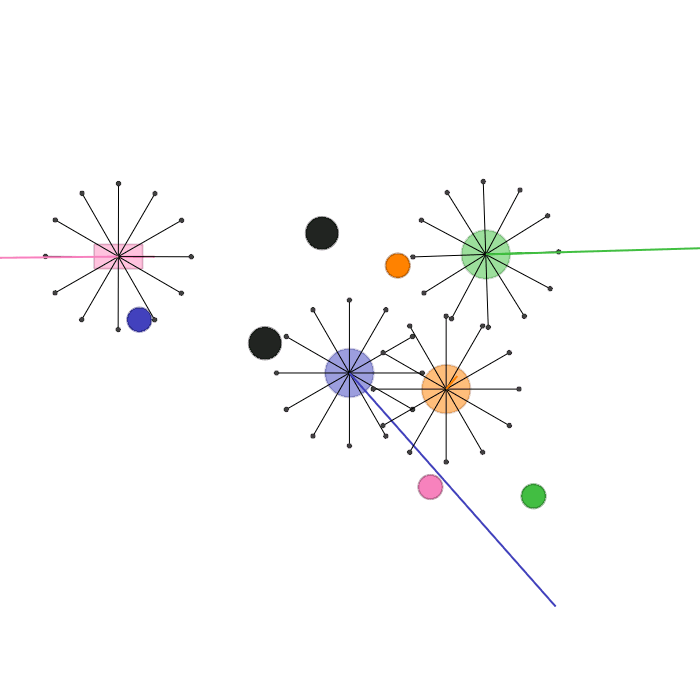

In [20]:
from IPython.display import Image
Image(f'{MyScenario.__name__}.gif')

Our agents (moving entities) are taking random actions, with their actions being plotted as lines of the same color.

The LIDAR sensor rays are plotted around the agents and these will shorten when they come in contact with other agents.

Obstacles are black circles and goals are the agent-colored circles.

The orange and blue agents are holonomic, the pink one is a car, and the green is the differential drive.

They are not doing much now as they are not trained, this is the goal of the next section in the notebook!

## Extensions

Lastly, before moving into training, how can you extend this scenario in you own time to make sure you understood VMAS properly?

**Making the scenario harder**.
To make the scnario haredr you can:
- Remove dense rewards and only use sparse ones
- Reduce the observations available (i.e., reduce lidar range, make goal less observable)
- Add more clutter. More agents. More obstacles. All in a tight space
- Add dynamical constraints. It is much harder to learn when you are not holonomic

**Other extensions**:
- Add another LIDAR for obstacles and remove them from observations [Beginner]
- Script one agent with a heuristic [Intermediate]
- Spawn 2 agents at a fixed distance and link them with a joint [Advanced]


# BenchMARL: training your custom scenario

[BenchMARL](https://benchmarl.readthedocs.io/en/latest/) is a library designed to reliably run and benchmark MARL algorithms, tasks, and models.

The core idea is that using it should be as simple as:

```bash
python benchmarl/run.py algorithm=mappo task=vmas/balance model=layers/mlp
```

Allowing you to choose independently **model, algorithm, and task**.

This further allows to mix and match them like
```bash
python benchmarl/run.py -m seed=0 task=vmas/balance model=layers/mlp algorithm=ippo,qmix,maddpg
```

Benchmarl decomposes this command in 3 experiment and runs and plots them for you like below:

![benchmarl-schema](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/benchmarl-schema.png)

So let's see how we can use BenchMARL to train the task just created.

We report all our interactive run results at https://wandb.ai/matteobettini/nav_tutorial?nw=nwusermatteobettini

## Installing depdendencies

In [ ]:
# @title Rendering dependencies
!apt-get update
!apt-get install -y x11-utils python3-opengl xvfb
!pip install pyvirtualdisplay torchvision "av<14"
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()

In [ ]:
# @title Install BenchMARL and VMAS
!pip install benchmarl vmas

Now let's install the dependencies for the GNN model, `torch_geometric`.

Since the GNN builds the topology from positions, we need the `radius_graph` function from `torch_cluster`, so we need to install that too. This is not needed if you use static (time-invariant) topologies.

This might take a little while. Not my fault, sorry

In [ ]:
# @title Install GNN dependencies
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

## Scenario recap


We report the cenario previously created in one code block

In [22]:
#  Copyright (c) 2025.
#  ProrokLab (https://www.proroklab.org/)
#  All rights reserved.

import typing
from typing import Dict, List

import torch

from torch import Tensor

from vmas import render_interactively
from vmas.simulator.core import Agent, Box, Landmark, Sphere, World
from vmas.simulator.dynamics.diff_drive import DiffDrive
from vmas.simulator.dynamics.holonomic import Holonomic
from vmas.simulator.dynamics.kinematic_bicycle import KinematicBicycle

from vmas.simulator.scenario import BaseScenario
from vmas.simulator.sensors import Lidar

from vmas.simulator.utils import (
    ANGULAR_FRICTION,
    Color,
    DRAG,
    LINEAR_FRICTION,
    ScenarioUtils,
)

if typing.TYPE_CHECKING:
    from vmas.simulator.rendering import Geom


class MyScenario(BaseScenario):
    def make_world(self, batch_dim: int, device: torch.device, **kwargs):
        ################
        # Scenario configuration
        ################
        self.plot_grid = False  # You can use this to plot a grid under the rendering for visualization purposes

        self.n_agents_holonomic = kwargs.pop(
            "n_agents_holonomic", 2
        )  # Number of agents with holonomic dynamics
        self.n_agents_diff_drive = kwargs.pop(
            "n_agents_diff_drive", 1
        )  # Number of agents with differential drive dynamics
        self.n_agents_car = kwargs.pop(
            "n_agents_car", 1
        )  # Number of agents with car dynamics
        self.n_agents = (
            self.n_agents_holonomic + self.n_agents_diff_drive + self.n_agents_car
        )
        self.n_obstacles = kwargs.pop("n_obstacles", 2)

        self.world_spawning_x = kwargs.pop(
            "world_spawning_x", 1
        )  # X-coordinate limit for entities spawning
        self.world_spawning_y = kwargs.pop(
            "world_spawning_y", 1
        )  # Y-coordinate limit for entities spawning

        self.comms_rendering_range = kwargs.pop(
            "comms_rendering_range", 0
        )  # Used for rendering communication lines between agents (just visual)
        self.lidar_range = kwargs.pop("lidar_range", 0.3)  # Range of the LIDAR sensor
        self.n_lidar_rays = kwargs.pop(
            "n_lidar_rays", 12
        )  # Number of LIDAR rays around the agent, each ray gives an observation between 0 and lidar_range

        self.shared_rew = kwargs.pop(
            "shared_rew", False
        )  # Whether the agents get a global or local reward for going to their goals
        self.final_reward = kwargs.pop(
            "final_reward", 0.01
        )  # Final reward that all the agents get when the scenario is done
        self.agent_collision_penalty = kwargs.pop(
            "agent_collision_penalty", -1
        )  # Penalty reward that an agent gets for colliding with another agent or obstacle

        self.agent_radius = kwargs.pop("agent_radius", 0.1)
        self.min_distance_between_entities = (
            self.agent_radius * 2 + 0.05
        )  # Minimum distance between entities at spawning time
        self.min_collision_distance = (
            0.005  # Minimum distance between entities for collision trigger
        )

        ScenarioUtils.check_kwargs_consumed(kwargs) # Warn is not all kwargs have been consumed


        ################
        # Make world
        ################
        world = World(
            batch_dim,  # Number of environments simulated
            device,  # Device for simulation
            substeps=5,  # Number of physical substeps (more yields more accurate but more expensive physics)
            collision_force=500,  # Paramneter to tune for collisions
            dt=0.1,  # Simulation timestep
            gravity=(0.0, 0.0),  # Customizable gravity
            drag=DRAG,  # Physics parameters
            linear_friction=LINEAR_FRICTION,  # Physics parameters
            angular_friction=ANGULAR_FRICTION,  # Physics parameters
            # There are many more....
        )

        ################
        # Add agents
        ################
        known_colors = [
            Color.BLUE,
            Color.ORANGE,
            Color.GREEN,
            Color.PINK,
            Color.PURPLE,
            Color.YELLOW,
            Color.RED,
        ]  # Colors for the first 7 agents
        colors = torch.randn(
            (max(self.n_agents - len(known_colors), 0), 3), device=device
        )  # Other colors if we have more agents are random

        self.goals = []  # We will store our agent goal entities here for easy access
        for i in range(self.n_agents):
            color = (
                known_colors[i]
                if i < len(known_colors)
                else colors[i - len(known_colors)]
            )  # Get color for agent

            sensors = [
                Lidar(
                    world,
                    n_rays=self.n_lidar_rays,
                    max_range=self.lidar_range,
                    entity_filter=lambda e: isinstance(
                        e, Agent
                    ),  # This makes sure that this lidar only percieves other agents
                    angle_start=0.0,  # LIDAR angular ranges (we sense 360 degrees)
                    angle_end=2
                    * torch.pi,  # LIDAR angular ranges (we sense 360 degrees)
                )
            ]  # Agent LIDAR sensor

            if i < self.n_agents_holonomic:
                agent = Agent(
                    name=f"holonomic_{i}",
                    collide=True,
                    color=color,
                    render_action=True,
                    sensors=sensors,
                    shape=Sphere(radius=self.agent_radius),
                    u_range=[1, 1],  # Ranges for actions
                    u_multiplier=[1, 1],  # Action multipliers
                    dynamics=Holonomic(),  # If you got to its class you can see it has 2 actions: force_x, and force_y
                )
            elif i < self.n_agents_holonomic + self.n_agents_diff_drive:
                agent = Agent(
                    name=f"diff_drive_{i - self.n_agents_holonomic}",
                    collide=True,
                    color=color,
                    render_action=True,
                    sensors=sensors,
                    shape=Sphere(radius=self.agent_radius),
                    u_range=[1, 1],  # Ranges for actions
                    u_multiplier=[0.5, 1],  # Action multipliers
                    dynamics=DiffDrive(
                        world
                    ),  # If you got to its class you can see it has 2 actions: forward velocity and angular velocity
                )
            else:
                max_steering_angle = torch.pi / 4
                width = self.agent_radius
                agent = Agent(
                    name=f"car_{i-self.n_agents_holonomic-self.n_agents_diff_drive}",
                    collide=True,
                    color=color,
                    render_action=True,
                    sensors=sensors,
                    shape=Box(length=self.agent_radius * 2, width=width),
                    u_range=[1, max_steering_angle],
                    u_multiplier=[0.5, 1],
                    dynamics=KinematicBicycle(
                        world,
                        width=width,
                        l_f=self.agent_radius,  # Distance between the front axle and the center of gravity
                        l_r=self.agent_radius,  # Distance between the rear axle and the center of gravity
                        max_steering_angle=max_steering_angle,
                    ),  # If you got to its class you can see it has 2 actions: forward velocity and steering angle
                )
            agent.pos_rew = torch.zeros(
                batch_dim, device=device
            )  # Tensor that will hold the position reward fo the agent
            agent.agent_collision_rew = (
                agent.pos_rew.clone()
            )  # Tensor that will hold the collision reward fo the agent

            world.add_agent(agent)  # Add the agent to the world

            ################
            # Add goals
            ################
            goal = Landmark(
                name=f"goal_{i}",
                collide=False,
                color=color,
            )
            world.add_landmark(goal)
            agent.goal = goal
            self.goals.append(goal)

        ################
        # Add obstacles
        ################
        self.obstacles = (
            []
        )  # We will store obstacles here for easy access
        for i in range(self.n_obstacles):
            obstacle = Landmark(
                name=f"obstacle_{i}",
                collide=True,
                color=Color.BLACK,
                shape=Sphere(radius=self.agent_radius * 2 / 3),
            )
            world.add_landmark(obstacle)
            self.obstacles.append(obstacle)

        self.pos_rew = torch.zeros(
            batch_dim, device=device
        )  # Tensor that will hold the global position reward
        self.final_rew = (
            self.pos_rew.clone()
        )  # Tensor that will hold the global done reward
        self.all_goal_reached = (
            self.pos_rew.clone()
        )  # Tensor indicating if all goals have been reached

        return world

    def reset_world_at(self, env_index: int = None):
        ScenarioUtils.spawn_entities_randomly(
            self.world.agents
            + self.obstacles
            + self.goals,  # List of entities to spawn
            self.world,
            env_index,  # Pass the env_index so we only reset what needs resetting
            self.min_distance_between_entities,
            x_bounds=(-self.world_spawning_x, self.world_spawning_x),
            y_bounds=(-self.world_spawning_y, self.world_spawning_y),
        )

        for agent in self.world.agents:
            if env_index is None:
                agent.goal_dist = torch.linalg.vector_norm(
                    agent.state.pos - agent.goal.state.pos,
                    dim=-1,
                )  # Tensor holding the distance of the agent to the goal, we will use it to compute the reward
            else:
                agent.goal_dist[env_index] = torch.linalg.vector_norm(
                    agent.state.pos[env_index] - agent.goal.state.pos[env_index]
                )

    def reward(self, agent: Agent):
        is_first = agent == self.world.agents[0]

        if is_first:
            # We can compute rewards when the first agent is called such that we do not have to recompute global components

            self.pos_rew[:] = 0  # Reset previous reward
            self.final_rew[:] = 0  # Reset previous reward

            for a in self.world.agents:
                a.agent_collision_rew[:] = 0  # Reset previous reward
                distance_to_goal = torch.linalg.vector_norm(
                    a.state.pos - a.goal.state.pos,
                    dim=-1,
                )
                a.on_goal = distance_to_goal < a.shape.circumscribed_radius()

                # The positional reward is the delta in distance to the goal.
                # This makes it so that if the agent moves 1m towards the goal it is rewarded
                # the same amount regardless of its absolute distance to it
                # This would not be the case if pos_rew = -distance_to_goal (a common choice)
                # This choice leads to better training
                a.pos_rew = a.goal_dist - distance_to_goal

                a.goal_dist = distance_to_goal  # Update distance to goal
                self.pos_rew += a.pos_rew  # Global pos reward

            # If all agents reached their goal we give them all a final_rew
            self.all_goal_reached = torch.all(
                torch.stack([a.on_goal for a in self.world.agents], dim=-1),
                dim=-1,
            )
            self.final_rew[self.all_goal_reached] = self.final_reward

            for i, a in enumerate(self.world.agents):
                # Agent-agent collision
                for j, b in enumerate(self.world.agents):
                    if i <= j:
                        continue
                    if self.world.collides(a, b):
                        distance = self.world.get_distance(a, b)
                        a.agent_collision_rew[
                            distance <= self.min_collision_distance
                        ] += self.agent_collision_penalty
                        b.agent_collision_rew[
                            distance <= self.min_collision_distance
                        ] += self.agent_collision_penalty
                # Agent obstacle collision
                for b in self.obstacles:
                    if self.world.collides(a, b):
                        distance = self.world.get_distance(a, b)
                        a.agent_collision_rew[
                            distance <= self.min_collision_distance
                        ] += self.agent_collision_penalty

        pos_reward = (
            self.pos_rew if self.shared_rew else agent.pos_rew
        )  # Choose global or local reward based on configuration
        return pos_reward + self.final_rew + agent.agent_collision_rew

    def observation(self, agent: Agent):
        obs = {
            "obs": torch.cat(
                [
                    agent.state.pos - agent.goal.state.pos
                ]  # Relative position to goal (fundamental)
                + [
                    agent.state.pos - obstacle.state.pos for obstacle in self.obstacles
                ]  # Relative position to obstacles (fundamental)
                + [
                    sensor._max_range - sensor.measure() for sensor in agent.sensors
                ],  # LIDAR to avoid other agents
                dim=-1,
            ),
            "pos": agent.state.pos,
            "vel": agent.state.vel,
        }
        if not isinstance(agent.dynamics, Holonomic):
            # Non hoonomic agents need to know angular states
            obs.update(
                {
                    "rot": agent.state.rot,
                    "ang_vel": agent.state.ang_vel,
                }
            )
        return obs

    def done(self) -> Tensor:
        return self.all_goal_reached

    def info(self, agent: Agent) -> Dict[str, Tensor]:
        return {
            "pos_rew": self.pos_rew if self.shared_rew else agent.pos_rew,
            "final_rew": self.final_rew,
            "agent_collision_rew": agent.agent_collision_rew,
        }

    def extra_render(self, env_index: int = 0) -> "List[Geom]":
        from vmas.simulator import rendering

        geoms = [
            ScenarioUtils.plot_entity_rotation(agent, env_index)
            for agent in self.world.agents
            if not isinstance(agent.dynamics, Holonomic)
        ]  # Plot the rotation for non-holonomic agents

        # Plot communication lines
        if self.comms_rendering_range > 0:
            for i, agent1 in enumerate(self.world.agents):
                for j, agent2 in enumerate(self.world.agents):
                    if j <= i:
                        continue
                    agent_dist = torch.linalg.vector_norm(
                        agent1.state.pos - agent2.state.pos, dim=-1
                    )
                    if agent_dist[env_index] <= self.comms_rendering_range:
                        color = Color.BLACK.value
                        line = rendering.Line(
                            (agent1.state.pos[env_index]),
                            (agent2.state.pos[env_index]),
                            width=1,
                        )
                        line.set_color(*color)
                        geoms.append(line)
        return geoms

## Adding our task to BenchMARL

Tasks in BenchMARL are `Enum`s.

This is so that you are able to use python autocompletion to choose from a discrete set of tasks and ease benchmarking.

Each environment/simulator compatible with BenchMARL is an enum with alements all its tasks.

This allows you to do stuff like the following:

In [23]:
from benchmarl.environments import VmasTask, Smacv2Task, PettingZooTask, MeltingPotTask
VmasTask.BALANCE # Try deleting the enum element name and see all the available ones
Smacv2Task.PROTOSS_10_VS_10 # Try deleting the enum element name and see all the available ones
PettingZooTask.MULTIWALKER # Try deleting the enum element name and see all the available ones
MeltingPotTask.COMMONS_HARVEST__OPEN # Try deleting the enum element name and see all the available ones


MeltingPotTask.COMMONS_HARVEST__OPEN: (config=None)

Cool uh?

To do this, BenchMARL needs to be quite stringent. Thus, to add a new task, you need to either:

1.   Add an enum element if the task is from an existing simulator
2.   Add a new task enum if it is from a new simulator

This will require you to also add a yaml config for the task and a schema python dataclass to validate this config (we really want to be strict in this process not to allow any bugs).

The full process is described in high detail here: https://github.com/facebookresearch/BenchMARL/tree/main/examples/extending/task

Now, we are in a notebook, so we cannot edit the BenchMARL files and add enum elements easily, so we will cheat slightly and make BenchMARL think that our newly created task is one of the already avaialble ones in the liibrary.

To do this, we override the `get_env_fun` of `VmasTask` to say: "if the user requests the NAVIGATION task, don't use the dafault one from VMAS, but use the one we just created".

I hope you will accept this white lie for the puropose of adding a new task in a notebook :) .

In [24]:
import copy
from typing import Callable, Optional
from benchmarl.environments import VmasTask
from benchmarl.utils import DEVICE_TYPING
from torchrl.envs import EnvBase, VmasEnv

def get_env_fun(
    self,
    num_envs: int,
    continuous_actions: bool,
    seed: Optional[int],
    device: DEVICE_TYPING,
) -> Callable[[], EnvBase]:
    config = copy.deepcopy(self.config)
    if (hasattr(self, "name") and self.name is "NAVIGATION") or (
        self is VmasTask.NAVIGATION
    ):  # This is the only modification we make ....
        scenario = MyScenario()  # .... ends here
    else:
        scenario = self.name.lower()
    return lambda: VmasEnv(
        scenario=scenario,
        num_envs=num_envs,
        continuous_actions=continuous_actions,
        seed=seed,
        device=device,
        categorical_actions=True,
        clamp_actions=True,
        **config,
    )

try:
    from benchmarl.environments import VmasClass
    VmasClass.get_env_fun = get_env_fun
except ImportError:
    VmasTask.get_env_fun = get_env_fun

## Training config

Let's first define some general parameters and then dive into creating each component

In [5]:
# @title Devices
train_device = "cpu" # @param {"type":"string"}
vmas_device = "cpu" # @param {"type":"string"}

### Experiment config

In [6]:
from benchmarl.experiment import ExperimentConfig

# Loads from "benchmarl/conf/experiment/base_experiment.yaml"
experiment_config = ExperimentConfig.get_from_yaml() # We start by loading the defaults

# Override devices
experiment_config.sampling_device = vmas_device
experiment_config.train_device = train_device

experiment_config.max_n_frames = 10_000_000 # Number of frames before training ends
experiment_config.gamma = 0.99
experiment_config.on_policy_collected_frames_per_batch = 60_000 # Number of frames collected each iteration
experiment_config.on_policy_n_envs_per_worker = 600 # Number of vmas vectorized enviornemnts (each will collect 100 steps, see max_steps in task_config -> 600 * 100 = 60_000 the number above)
experiment_config.on_policy_n_minibatch_iters = 45
experiment_config.on_policy_minibatch_size = 4096
experiment_config.evaluation = True
experiment_config.render = True
experiment_config.share_policy_params = True # Policy parameter sharing on
experiment_config.evaluation_interval = 120_000 # Interval in terms of frames, will evaluate every 120_000 / 60_000 = 2 iterations
experiment_config.evaluation_episodes = 200 # Number of vmas vectorized enviornemnts used in evaluation
experiment_config.loggers = ["csv"] # Log to csv, usually you should use wandb

### Task config

In [7]:
# Loads from "benchmarl/conf/task/vmas/navigation.yaml"
task = VmasTask.NAVIGATION.get_from_yaml()

# We override the NAVIGATION config with ours
task.config = {
        "max_steps": 100,
        "n_agents_holonomic": 2,
        "n_agents_diff_drive": 1,
        "n_agents_car": 1,
        "lidar_range": 0.35,
        "comms_rendering_range": 0,
        "shared_rew": False,
}

### Algorithm config

In [8]:
from benchmarl.algorithms import MappoConfig

# We can load from "benchmarl/conf/algorithm/mappo.yaml"
algorithm_config = MappoConfig.get_from_yaml()

# Or create it from scratch
algorithm_config = MappoConfig(
        share_param_critic=True, # Critic param sharing on
        clip_epsilon=0.2,
        entropy_coef=0.001, # We modify this, default is 0
        critic_coef=1,
        loss_critic_type="l2",
        lmbda=0.9,
        scale_mapping="biased_softplus_1.0", # Mapping for standard deviation
        use_tanh_normal=True,
        minibatch_advantage=False,
    )

### Model config

In [9]:
from benchmarl.models.mlp import MlpConfig

model_config = MlpConfig(
        num_cells=[256, 256], # Two layers with 256 neurons each
        layer_class=torch.nn.Linear,
        activation_class=torch.nn.Tanh,
    )

# Loads from "benchmarl/conf/model/layers/mlp.yaml" (in this case we use the defaults so it is the same)
model_config = MlpConfig.get_from_yaml()
critic_model_config = MlpConfig.get_from_yaml()

## Train with physically heterogeneous agents

We are now ready to train our scenario!

This is super simple, just a few lines of code.

We have already trained this for `50_000_000` frames with the wandb logger for you.

The intercative plots generated by BenchMARL are here: https://wandb.ai/matteobettini/nav_tutorial/runs/mappo_navigation_mlp__98e76926_25_02_05-11_05_26/workspace?nw=nwusermatteobettini

In [25]:
from benchmarl.experiment import Experiment

experiment_config.max_n_frames = 6_000 # Runs one iteration, change to 50_000_000 for full training
experiment_config.on_policy_n_envs_per_worker = 60 # Remove this line for full training
experiment_config.on_policy_n_minibatch_iters = 1 # Remove this line for full training

experiment = Experiment(
    task=task,
    algorithm_config=algorithm_config,
    model_config=model_config,
    critic_model_config=critic_model_config,
    seed=0,
    config=experiment_config,
)
experiment.run()

mean return = -0.5155945420265198: 100%|██████████| 1/1 [00:50<00:00, 50.55s/it]


Here are the agents after full training:

![](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/tutorial_gifs/Trainwithphysicallyheterogeneousagents.gif)

We will not go too much into the inner workings of BenchMARL.

One thing worth noting is that BenchMARL will automatically group agents based on the VMAS name (all cars togherther, all holonomic together, all differential drive together). This allows to stack their data because they are homogeneous.

Agents from different groups will be kept separate and it is even possible to use different models and algorithms for different groups. See https://github.com/facebookresearch/BenchMARL/tree/main/examples/ensemble

For more details on the grouping mechanism see https://www.youtube.com/watch?v=1tOIMgJf_VQ&t=1786s



## Train with physically homogenous agents

Now, let's change the task a bit, and let's have only one type of agent: the holonomic one.

In [26]:
task.config = {
        "max_steps": 100,
        "n_agents_holonomic": 4, # Changed
        "n_agents_diff_drive": 0,  # Changed
        "n_agents_car": 0,  # Changed
        "lidar_range": 0.35,
        "comms_rendering_range": 0,
        "shared_rew": False,
}

This is because in a few sections we will use the GNN model and GNNs work only within a group of agent. So doing this puts all our agents in one "holonomic" group.

Let's train again.

The intercative plots generated by BenchMARL are here: https://wandb.ai/matteobettini/nav_tutorial/runs/mappo_navigation_mlp__9375e68c_25_02_05-11_06_15/workspace?nw=nwusermatteobettini

In [27]:
from benchmarl.experiment import Experiment

experiment_config.max_n_frames = 6_000 # Runs one iteration, change to 50_000_000 for full training
experiment_config.on_policy_n_envs_per_worker = 60 # Remove this line for full training
experiment_config.on_policy_n_minibatch_iters = 1 # Remove this line for full training

experiment = Experiment(
    task=task,
    algorithm_config=algorithm_config,
    model_config=model_config,
    critic_model_config=critic_model_config,
    seed=0,
    config=experiment_config,
)
experiment.run()

mean return = -0.513882040977478: 100%|██████████| 1/1 [00:51<00:00, 51.22s/it]


Here are the agents after full training:

![](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/tutorial_gifs/Trainwithphysicallyhomogenousagents.gif)

In the wandb panel you should see that the agents are doing the task pretty well!

Keep an eye on collision penalties by looking at the `collection/holonomic/info/agent_collision_rew panel`.

**Agents are learning to avoid collsions!**

## Train without LIDAR

Now, what happens if we disable the LIDAR? (set its range to 0)



In [28]:
task.config = {
        "max_steps": 100,
        "n_agents_holonomic": 4,
        "n_agents_diff_drive": 0,
        "n_agents_car": 0,
        "lidar_range": 0, # Changed
        "comms_rendering_range": 0,
        "shared_rew": False,
}

The result should be that the agents have now no way of avoiding each other.


The intercative plots generated by BenchMARL are here: https://wandb.ai/matteobettini/nav_tutorial/runs/mappo_navigation_mlp__84e35613_25_02_05-14_12_51/workspace?nw=nwusermatteobettini

In [29]:
from benchmarl.experiment import Experiment

experiment_config.max_n_frames = 6_000 # Runs one iteration, change to 50_000_000 for full training
experiment_config.on_policy_n_envs_per_worker = 60 # Remove this line for full training
experiment_config.on_policy_n_minibatch_iters = 1 # Remove this line for full training

experiment = Experiment(
    task=task,
    algorithm_config=algorithm_config,
    model_config=model_config,
    critic_model_config=critic_model_config,
    seed=0,
    config=experiment_config,
)
experiment.run()

mean return = -0.5155945420265198: 100%|██████████| 1/1 [00:52<00:00, 52.70s/it]


Here are the agents after full training:

![](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/tutorial_gifs/TrainwithoutLIDAR.gif)

Keep an eye on collision penalties by looking at the `collection/holonomic/info/agent_collision_rew` panel.

**Agents are not able to avoid collisions!**

## Train without LIDAR with GNN

So how do we solve this problem?

Our agents need to navigate to their goals and are not able to use their LIDARs anymore to avoid collisions.

Well, we could do something about this by allowing them to talk to each othter!

This, in fact, would be even better as instead of considering other agents' like dynamic obstacles trhough the LIDAR, with communication they should be able to share any information within the policy.

#### Graph Neural Networks (GNNs) for communication in MARL

Our solution is using GNNs as a layer in the agents' policy to allow information exchange.

The topology of the GNN can be built dynamically based on agent proximity (like traditional communication models). This is cool for 2 reasons:

1.   Agents can avoid talking to far away agents and thus avoid conditioning their input on them
2.   Agents just need to share information in neighbourhoods and thus you can avoid centralised training and execution is still decentralised.

We have used GNNs as policies in a number of papers: see https://arxiv.org/abs/2111.01777 and https://arxiv.org/abs/2301.07137



#### GNNs in BenchMARL

Let's build our GNN model in BenchMARL.

We first define the communicatiuon radius used to build the GNN topology at every step

In [30]:
# @title Communication radius
comms_radius = 1 # @param {"type":"number"}


Let's define the GNN config.

We will tell the GNN where to read agent positions (`pos` in observation) and veleocities (`vel` in observation). We also tell the GNN that each of these keys has 2 features (VMAS is 2D).

Then, the GNN, will use them to build edge features, in paricular:
- Relative position $\mathbf{x}_i-\mathbf{x}_j$
- Distance $||\mathbf{x}_i-\mathbf{x}_j||$
- Relative velocity  $\mathbf{v}_i-\mathbf{v}_j$

These edge features are key for the agents to avoid collisions.

We can choose any GNN layer from [`torch_geometric.nn.conv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers) but we should choose one that uses edge features.

`GATv2Conv` is a pretty cool one that uses attention (like a transformer) to weight messages incoming from neigbours.

For more details on how the GNN works see [here](https://benchmarl.readthedocs.io/en/latest/generated/benchmarl.models.Gnn.html#benchmarl.models.Gnn) and the FAQs [here](https://github.com/facebookresearch/BenchMARL/issues/157)


In [31]:
from benchmarl.models import GnnConfig, SequenceModelConfig
import torch_geometric

gnn_config = GnnConfig(
    topology="from_pos", # Tell the GNN to build topology from positions and edge_radius
    edge_radius=comms_radius, # The edge radius for the topology
    self_loops=False,
    gnn_class=torch_geometric.nn.conv.GATv2Conv,
    gnn_kwargs={"add_self_loops": False, "residual": True}, # kwargs of GATv2Conv, residual is helpful in RL
    position_key="pos",
    pos_features=2,
    velocity_key="vel",
    vel_features=2,
    exclude_pos_from_node_features=True, # Do we want to use pos just to build edge features or also keep it in node features? Here we remove it as we want to be invariant to system translations (we do not use absolute positions)
)
# We add an MLP layer to process GNN output node embeddings into actions
mlp_config = MlpConfig.get_from_yaml()

# Chain them in a sequence
model_config = SequenceModelConfig(model_configs=[gnn_config, mlp_config], intermediate_sizes=[256])

And let's tell the VMAS task what comms_radius we are using so it can plot some nice communication lines when agents are in proximity.

This is just nice to have for visualization.


In [32]:
task.config = {
        "max_steps": 100,
        "n_agents_holonomic": 4,
        "n_agents_diff_drive": 0,
        "n_agents_car": 0,
        "lidar_range": 0,
        "comms_rendering_range": comms_radius, # Changed
        "shared_rew": False,
}

We are now ready to train!

The intercative plots generated by BenchMARL are here: https://wandb.ai/matteobettini/nav_tutorial/runs/mappo_navigation_sequencemodel__ddd9fc72_25_02_05-11_14_42/workspace?nw=nwusermatteobettini

In [33]:
from benchmarl.experiment import Experiment

experiment_config.max_n_frames = 6_000 # Runs one iteration, change to 50_000_000 for full training
experiment_config.on_policy_n_envs_per_worker = 60 # Remove this line for full training
experiment_config.on_policy_n_minibatch_iters = 1 # Remove this line for full training

experiment = Experiment(
    task=task,
    algorithm_config=algorithm_config,
    model_config=model_config,
    critic_model_config=critic_model_config,
    seed=0,
    config=experiment_config,
)
experiment.run()

mean return = -0.5155945420265198: 100%|██████████| 1/1 [00:50<00:00, 50.75s/it]


Here are the agents after full training:

![](https://raw.githubusercontent.com/matteobettini/vmas-media/refs/heads/main/media/tutorial_gifs/TrainwithoutLIDARwithGNN.gif)

As you can see the agents were able to use the GNN communication to avoid collisions

## Extensions

Here are a few things you can try in your own time.

**Beginner**:
- Change the algorithm and compare algorithms (algorithms that support only discrete actions will use those)
- Change the model. For example you can add a memory layer
- Train the agents with a shared reward by changing the task configuration

**Intermediate**:
- Try to disable parameter sharing think about its implications
- MAPPO uses a centralised critic which takes as input the concatenation of all agents observations. This is not scalable in the number of agents. Try using a [DeepSets](https://benchmarl.readthedocs.io/en/latest/generated/benchmarl.models.Deepsets.html#benchmarl.models.Deepsets) model instead for the critic
- Use different models or algorthms for each group using the [ensemble components](https://benchmarl.readthedocs.io/en/latest/concepts/features.html#ensemble-models-and-algorithms).

**Advanced**:
- Set up a reward curriculum using [callbacks](https://github.com/facebookresearch/BenchMARL/tree/main/examples/callback). Start from a dense reward and slowly anneal it leaving only the sparse one
- Implement [GPPO](https://arxiv.org/abs/2301.07137) by using a GNN for both the actor and critic and sharing the GNN layer parameters between actor and critic. Hint: you can use a callback and [this function](https://github.com/facebookresearch/BenchMARL/blob/7ae02107df151a4a2eb002d61ce3426c9c002cec/benchmarl/models/common.py#L165). You will also have to change the algorithm to IPPO
